# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

In [1]:
# Standard modules
import time
import numpy as np
import matplotlib.pyplot as plt

# My own script (an interface to the simulator)
import ae353_spacecraft_simulate

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

Here are two rules of thumb about the `display` argument:
* When doing development, turn the display on (`display=True`).
* When collecting data or saving a video, turn the display off (`display=False`).

If you are having trouble with the in-browser display — e.g., if it is running slowly on your laptop — then you can try the pybullet display instead (`display=False` and `display_pybullet=True`).

The `seed` argument (an integer, default `None`) initializes the random number generator that is used by the simulator.

In [2]:
simulator = ae353_spacecraft_simulate.Simulator(
    display=True,
    seed=None,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Choose a camera view from the following options:

* `camera_sideview()`
* `camera_scopeview()`
* `camera_catview()`

In [3]:
simulator.camera_sideview()

Define a controller that maps sensor measurements to actuator commands. By default, it applies zero torque to each reaction wheel. Modify the `run` function to make the controller behave differently. This function will be called 25 times per second (i.e., at 25 Hz) by the simulator.

In [3]:
class Controller:
    def __init__(self):
        # FIXME: add class variable names to this list (e.g., 'xhat')
        # if you want these variables to be logged by the simulator
        self.K = np.array([[ -0.        ,  -7.07106781,  -0.        ,   0.        ,
        -14.75593147,  -0.        ],
       [  0.        ,  -0.        ,  10.        ,  24.93290998,
         -0.        ,   0.        ],
       [  0.        ,   7.07106781,   0.        ,  -0.        ,
         14.75593147,   0.        ],
       [ 10.        ,  -0.        ,   0.        ,   0.        ,
          0.        ,  24.93290998]])

        
        self.A = np.array([[ 0.,  0.,  0.,  0.,  0.,  1.],
                           [ 0.,  0., -0.,  0.,  1., -0.],
                           [ 0.,  0.,  0.,  1.,  0.,  0.],
                           [ 0.,  0.,  0.,  0., -0., -0.],
                           [ 0.,  0.,  0.,  0.,  0.,  0.],
                            [ 0.,  0.,  0.,  0.,  0.,  0.]])
        self.B =  np.array([[ 0.,  0.,  0.,  0.],
                            [ 0.,  0.,  0.,  0.],
                           [ 0.,  0.,  0.,  0.],
                           [-0.,  0.03833988,  0., -0.],
                           [-0.04215555, -0.,  0.04215555,  0.],
                           [ 0.,  0.,  0.,  0.03833988]])

        
        self.C = np.array([[-2.625     ,  0.        , -2.651426  ,  0.02655868, -2.625     ,
         0.        ],
       [-0.        ,  2.651426  , -0.02655868,  2.65169203,  0.        ,
         2.651426  ],
       [ 0.26337851,  0.        , -0.26470092, -0.26337851, -0.26337851,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

        self.dt = (1/25)

        self.L = np.array([[-0.19792576, -0.02163259,  0.4897433 ,  0.        ,  0.        ,
         0.        ],
       [ 0.13673611,  0.30632324, -0.0075213 ,  0.        ,  0.        ,
         0.        ],
       [-0.18380976, -0.07489003, -0.48554779,  0.        ,  0.        ,
         0.        ],
       [-0.06941481,  0.00500694, -0.07180887,  0.        ,  0.        ,
         0.        ],
       [ 0.01180116,  0.09919962, -0.00449092,  0.        ,  0.        ,
         0.        ],
       [-0.07100927,  0.01159164,  0.06945011,  0.        ,  0.        ,
         0.        ]])
        
        self.variables_to_log = []
        
    
    def reset(self):
        self.xhat = np.array([0.0,0.0,0.0,0.0,0.0,0.0]).T
        pass
    
    def run(self, t, star_measurements):
        """
        The variable t is the current time.

        The variable star_measurements is a 1d array of length twice the
        number N of stars:

            [y_1, z_1, y_2, z_2, ..., y_N, z_N]
        
        The image coordinates y_i and z_i of the i'th star (for i = 1, ..., N)
        are at index 2 * i - 2 and 2 * i - 1 of this array, respectively.
        """
        u = -self.K@self.xhat

        y = star_measurements - np.array([0, 0.263378514224308, 0.263378514224308, -0.264700916252661, 0, -0.263378514224308])
        
        self.xhat += self.dt*(self.A@self.xhat+self.B@u-self.L@(self.C@self.xhat-y))
        #self.data['psiH'] = self.xhat[0]
        # FIXME: replace the following lines
        torque_1 = u[0]
        torque_2 = u[1]
        torque_3 = u[2]
        torque_4 = u[3]
        
        return torque_1, torque_2, torque_3, torque_4

Create an instance of the controller.

In [4]:
controller = Controller()

You could reset the simulator with given initial conditions.

In [5]:
simulator.reset(
    initial_conditions={
        'psi': 0.,
        'theta': 0.,
        'phi': 0.,
        'w_x': 0.,
        'w_y': 0.,
        'w_z': 0.,
    },
    scope_noise=0.0,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=False,      # <-- whether or not there is space debris
    docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Or, you could reset the simulator with initial conditions sampled at random (in particular, each initial condition will be sampled from a normal distribution that has mean $\mu=0.0$ and standard deviation $\sigma = 0.1$).

In [7]:
simulator.reset(
    initial_conditions=None,
    scope_noise=0.0,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=False,      # <-- whether or not there is space debris
    docking_time=10.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Reset the controller.

In [6]:
controller.reset()

Run the simulator. It will quit when one of the following conditions is satisfied:

* Any star goes out of view of the scope.
* Any reaction wheel has angular velocity exceeding +/- 50 rad/s.
* The maximum time is reached.

In [7]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=10,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)

Check if the space-cat has docked.

In [8]:
has_docked = simulator.has_docked()
if has_docked:
    print('The space-cat docked.')
else:
    print('The space-cat did not dock.')

The space-cat did not dock.


Get, show, and save a snapshot of the simulation after the last time step.

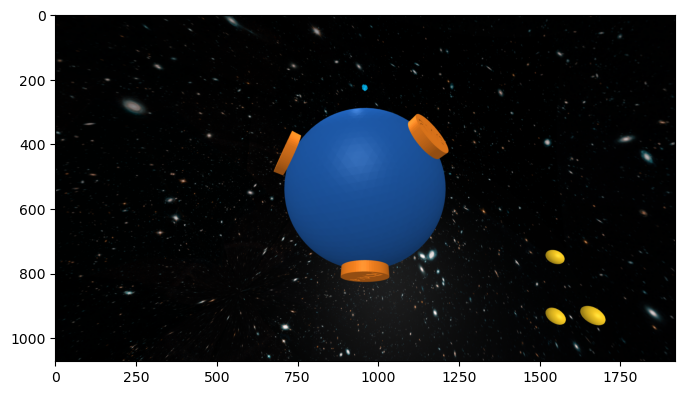

In [9]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Get, show, and save a snapshot of the simulation from a side view, with a picture-in-picture view from the scope.

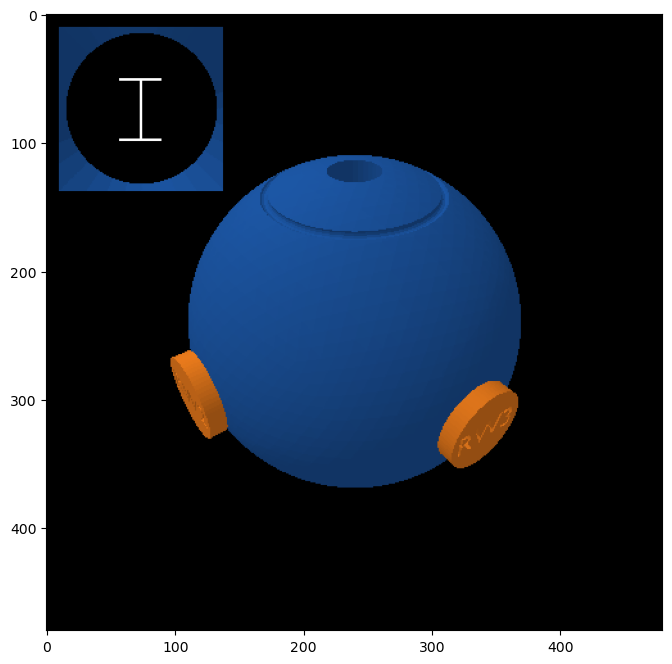

In [10]:
# Get snapshot as height x width x 4 numpy array of RGBA values
# with a picture-in-picture view of the scope
rgba = simulator.pybullet_snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results. (This code is meant only for development. You will want to create different and better plots for your own report.)

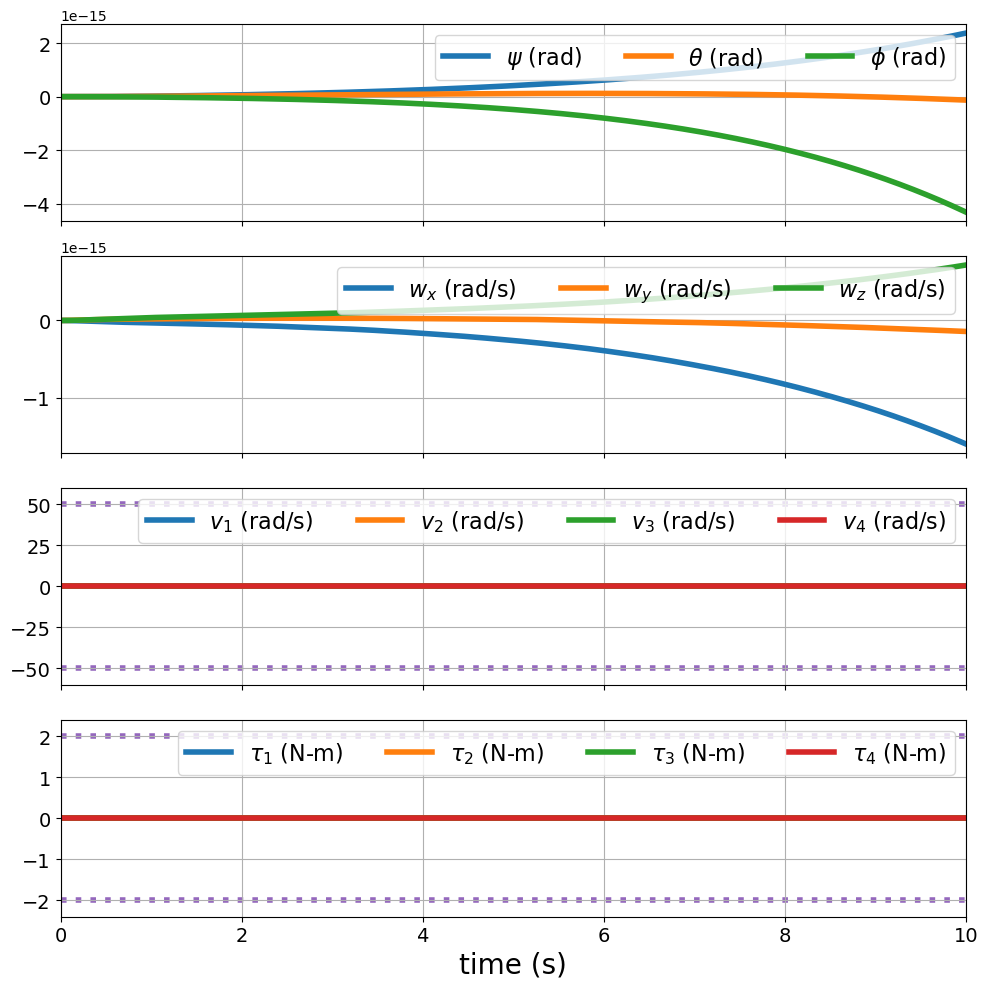

In [11]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_vel, ax_rwvel, ax_rwtau) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['psi'], label=r'$\psi$ (rad)', linewidth=4)
#ax_ori.plot(data['t'], data['psiH'], label=r'$\psiH$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['theta'], label=r'$\theta$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['phi'], label=r'$\phi$ (rad)', linewidth=4)
ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='upper right')
ax_ori.tick_params(labelsize=14)

# Plot x, y, z components of angular velocity
ax_vel.plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=4)
ax_vel.grid()
ax_vel.legend(fontsize=16, ncol=3, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['wheel_1_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_2_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_3_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_4_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)

# Plot torque applied to each reaction wheel
ax_rwtau.plot(data['t'], data['torque_1'], label=r'$\tau_1$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_2'], label=r'$\tau_2$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_3'], label=r'$\tau_3$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_4'], label=r'$\tau_4$ (N-m)', linewidth=4)
ax_rwtau.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.grid()
ax_rwtau.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwtau.tick_params(labelsize=14)


# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_rwtau.set_xlabel('time (s)', fontsize=20)
ax_rwtau.set_xlim([data['t'][0], data['t'][-1]])
ax_rwtau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [83]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot star positions in image. This is not necessarily a useful thing to plot. The point is to show how to access measurements of star position from logged data.

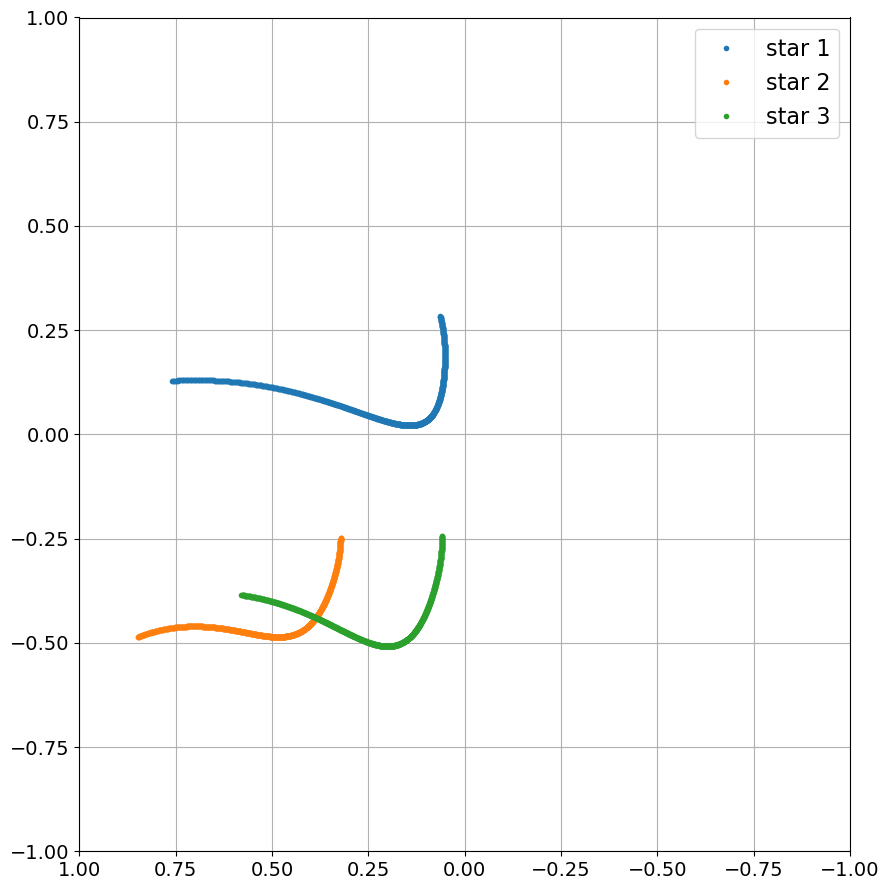

In [84]:
# Create a figure with one subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Scatter-plot the position of all stars at all time steps in the scope
for i in range(len(simulator.stars)):
    y = data['star_meas'][:, 2 * i]
    z = data['star_meas'][:, 2 * i + 1]
    ax.plot(y, z, label=f'star {i + 1}', linestyle='none', marker='.', markersize=6)

# Change appearance of axes
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(1., -1.) # <-- the "y_star" axis points left (not right)
ax.set_ylim(-1., 1.) # <-- the "z_star" axis points up

# Make the arrangement of subplots look nice
fig.tight_layout()